## Scattered data interpolation via unregularized or regularized linear deconvolution

This notebook describes and compares several methods of scattered data interpolation.

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import scipy.optimize as optimize
import pygsvd
import crr.scattered.sampling as sampling
import crr.scattered.roll_zeropad as roll_zeropad
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = [9., 7.]
dpi = 100

The plot below shows the sampling (with the size of the points proportional to the width of the kernel.

In [4]:
samples = sampling.Sampling(nsamples=1000)

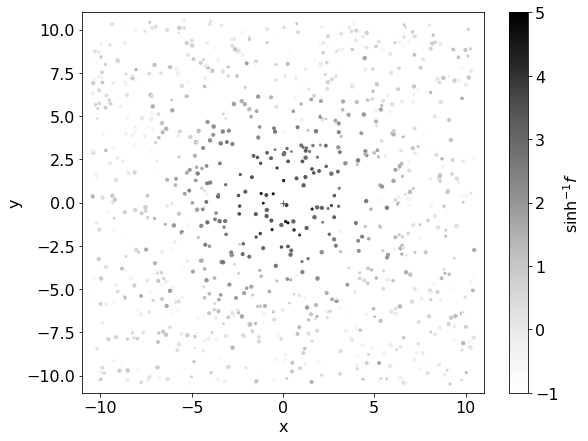

In [17]:
samples.set_flux(total_flux=1000., noise=1.e-0)
samples.imshow()

We will reconstruct on a 21 by 21 grid, with the $x$ and $y$ coordinates set below (with coordinate $(0,0)$ at pixel center $(10, 10)$), and pixels space each unit of distance in the space.

### Modelling the image

Relevant to some, though not all, methods of interpolation of scattered data is the idea of a model image that explains our sampled fluxes. To do so, we will define:

 * The vector of samples $\vec{f}$, of length $N$,
 * A model image $\vec{F}$, which represents a regular grid of delta functions, with a total of $M$ grid points, and
 * The kernel transformation ${\mathbf A}$, an $N\times M$ matrix.

The kernel transformation defines how each sample responds to the delta function in the model image. We can build it with successive calls to the code that generates the fluxes. Under these definitions a model $\vec{m}$ can be written as:

$$\vec{m} = {\mathbf A} \cdot \vec{f}$$

Once we have ${\mathbf A}$ we can fit the parameters in the model image $\vec{F}$.  We minimize:

$$\chi^2 = \left(\vec{m} - \vec{f}\right)\cdot {\mathbf N}^{-1} \cdot \left(\vec{m} - \vec{f}\right)$$

To find the values of $\vec{F}$ minimize $\chi^2$, we apply singular value decomposition as follows:

$${\mathbf N}^{1/2} {\mathbf A} = {\mathbf U} \cdot \Sigma \cdot {\mathbf V}^T$$

That makes the inversion of the problem easy so it is:

$$\vec{F} = {\mathbf V}\cdot\Sigma \cdot {\mathbf U}^T \cdot {\mathbf N}^{-1/2} \cdot \vec{f} $$

The covariance of this image can be calculated as:

$${\mathbf C}_F^{-1} = {\mathbf A}^T\cdot{\mathbf N}^{-1}\cdot{\mathbf A}$$


We can create a noiseless image and perform the fit. This works great. It is very closely equivalent to a full image deconvolution.

In [18]:
(U, S, VT) = np.linalg.svd(samples.A, full_matrices=False)
Sinv = np.zeros(len(S))
Sinv[S > 0] = 1. / S[S > 0] 
W_F = VT.T.dot(np.diag(Sinv)).dot(U.T)
S_F = W_F.dot(samples.flux_nonoise)
S_F = S_F.reshape((samples.nx, samples.ny))

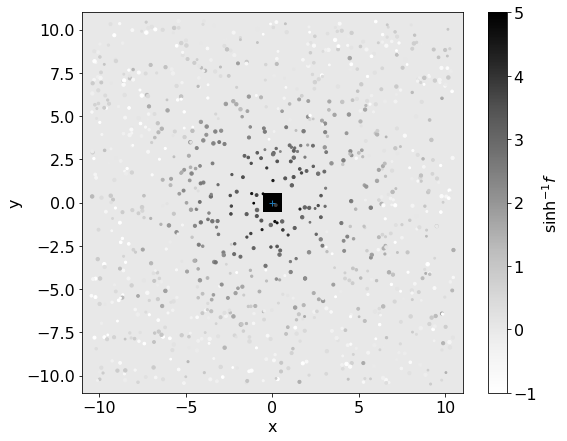

In [19]:
samples.imshow(S_F)

But if we add even a tiny amount of noise this runs into terrible trouble. Even $10^{-6}$ level noise leads to a very troublesome covariance matrix, which leads to strong fluctuations.

In [20]:
samples.set_flux(total_flux=1000., noise=1.e-0)
S_F = W_F.dot(samples.flux)
S_F = S_F.reshape((samples.nx, samples.ny))

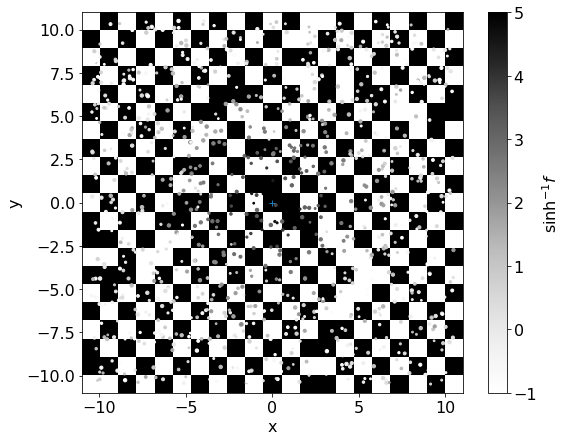

In [21]:
samples.imshow(S_F)

The covariance matrix of this result can be calculated and clearly shows these issues.

Text(0, 0.5, 'pixel $j$')

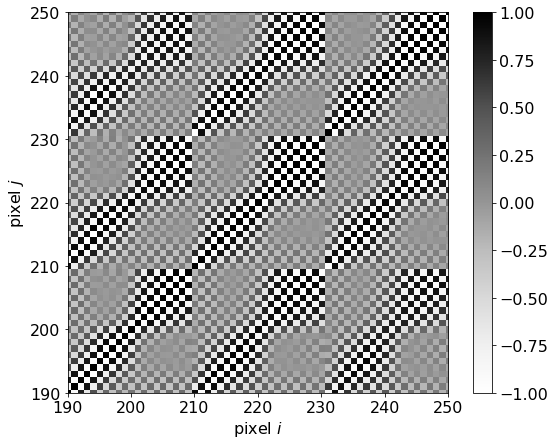

In [22]:
C_F = W_F.dot(W_F.T)
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys, 'vmin': -1., 'vmax': 1}
CC_F = 0. * C_F
for i in np.arange(samples.nx * samples.ny):
    for j in np.arange(samples.nx * samples.ny):
        CC_F[i, j] = C_F[i, j] / np.sqrt(C_F[i, i] * C_F[j, j])
plt.imshow(CC_F, **myargs)
nmid = (samples.nx * samples.ny) // 2
plt.xlim([nmid - 30, nmid + 30])
plt.ylim([nmid - 30, nmid + 30])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')

A very common approach to handling these issues is to regularize the fit. The simplest form of regularization is Tikhonov regularization. In its simplest form, it is designed to quadratically favor reconstruction values near zero. This case simply reduces to a conversion of the singular values that causes their inverse to smoothly go to zero below a value of $\Sigma \sim \lambda$. We can ask what this does, in the case of noise and no noise. The noiseless case is very enlightening. The PSF of this method is extremely irregular even for small values of $\lambda$.

In [85]:
llambda = 3.e-1
(U, S, VT) = np.linalg.svd(samples.A, full_matrices=False)
Sinv = np.zeros(len(S))
Sinv = S / (S**2 + llambda**2)
W_Ts = VT.T.dot(np.diag(Sinv)).dot(U.T)
S_Ts = W_Ts.dot(samples.flux)
S_Ts = S_Ts.reshape((samples.nx, samples.ny))

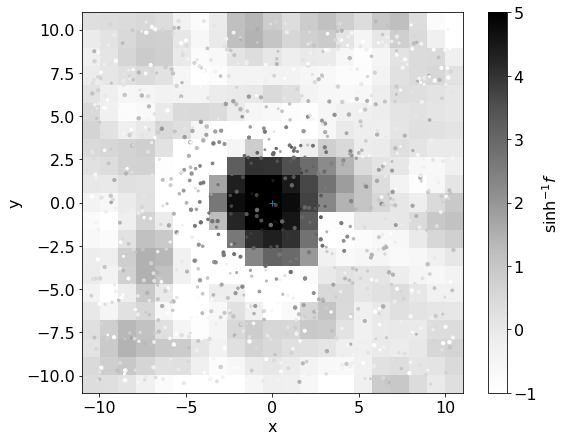

In [86]:
samples.imshow(S_Ts)

In [87]:
S_Ts = W_Ts.dot(samples.flux_nonoise)
S_Ts = S_Ts.reshape((samples.nx, samples.ny))

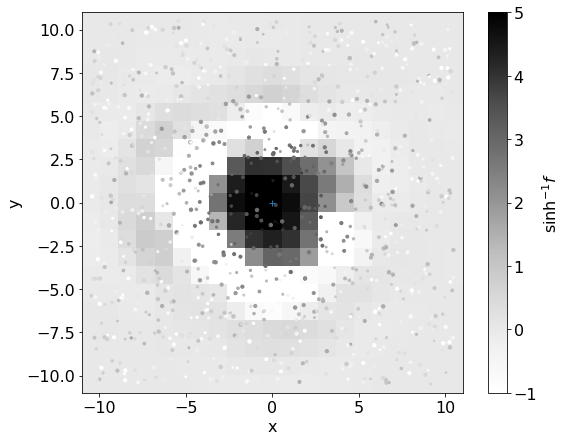

In [88]:
samples.imshow(S_Ts)

Text(0, 0.5, 'pixel $j$')

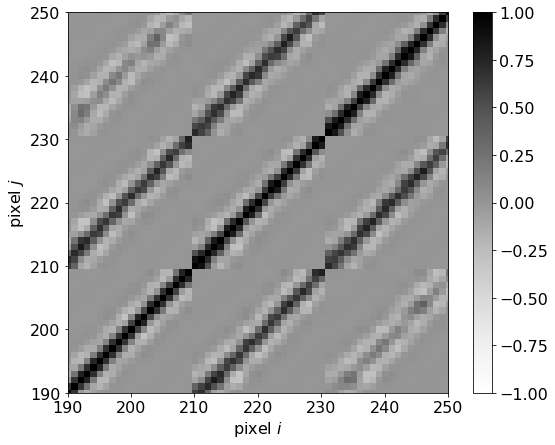

In [89]:
C_Ts = W_Ts.dot(W_Ts.T)
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys, 'vmin': -1., 'vmax': 1}
CC_Ts = 0. * C_Ts
for i in np.arange(samples.nx * samples.ny):
    for j in np.arange(samples.nx * samples.ny):
        CC_Ts[i, j] = C_Ts[i, j] / np.sqrt(C_Ts[i, i] * C_Ts[j, j])
plt.imshow(CC_Ts, **myargs)
nmid = (samples.nx * samples.ny) // 2
plt.xlim([nmid - 30, nmid + 30])
plt.ylim([nmid - 30, nmid + 30])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')

There are more complicated ways of regularizing even in the Tikhonov case. In particular, one can construct $\Gamma$ to favor minimizing the squared differences of neighboring pixels. We can solve this problem using generalized SVD. First we will test that it works on the simplest Tikhonov case. It matches perfectly.

In [44]:
N = samples.nx * samples.ny
Gamma = np.diag(np.ones(N))
(sigma1_gs, sigma2_gs, X_gs, U_gs, V_gs) = pygsvd.gsvd(samples.A, Gamma, extras='uv')

In [45]:
XTinv_gs = np.linalg.inv(X_gs.T)

In [46]:
llambda = 3.e-3
sigmat_gs = np.diag(1. / (sigma1_gs * sigma1_gs + llambda**2 * sigma2_gs * sigma2_gs))
W_Tgs = XTinv_gs.dot(sigmat_gs).dot(np.diag(sigma1_gs)).dot(U_gs.T)

In [47]:
S_Tgs = W_Tgs.dot(samples.flux_nonoise)
S_Tgs = S_Tgs.reshape((samples.nx, samples.ny))

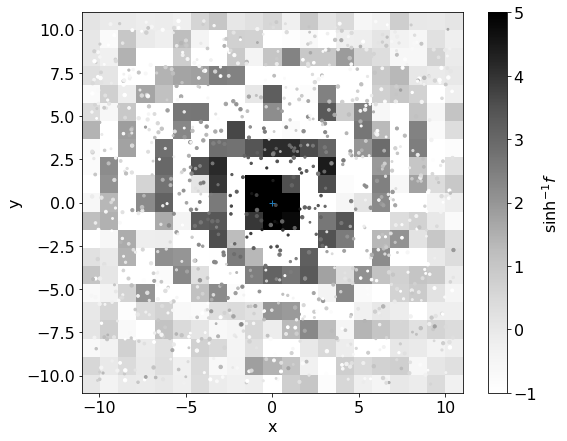

In [48]:
samples.imshow(S_Tgs)

Now we construct $\Gamma$ that minimizes the squared error between neighboring pixels. This is somewhat different but also shows that the PSF for this case is a complicated beast with a lot of ringing.

In [49]:
nx = samples.nx
ny = samples.ny
Gamma = np.zeros((nx * ny, nx * ny))
ident = np.diag(np.ones(nx * ny)).reshape(nx, ny, nx, ny)
sident = - roll_zeropad.roll_zeropad(ident, -1, axis=2)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad.roll_zeropad(ident, 1, axis=2)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad.roll_zeropad(ident, -1, axis=3)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad.roll_zeropad(ident, 1, axis=3)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
for indx in np.arange(nx * ny):
    Gammasum = - Gamma[indx, :].sum()
    Gamma[indx, :] = Gamma[indx, :] / Gammasum
    Gamma[indx, indx] = 1.

In [50]:
(sigma1_g, sigma2_g, X_g, U_g, V_g) = pygsvd.gsvd(samples.A, Gamma, extras='uv')

In [51]:
XTinv_g = np.linalg.inv(X_g.T)

In [67]:
llambda = 3.e-2
sigmat_g = np.diag(1. / (sigma1_g * sigma1_g + llambda**2 * sigma2_g * sigma2_g))
W_Tg = XTinv_g.dot(sigmat_g).dot(np.diag(sigma1_g)).dot(U_g.T)

In [68]:
S_Tg = W_Tg.dot(samples.flux_nonoise)
S_Tg = S_Tg.reshape((nx, ny))

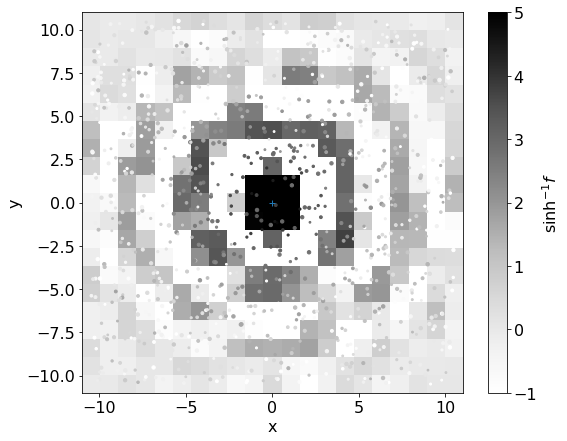

In [69]:
samples.imshow(S_Tg)

In [70]:
samples.set_flux(total_flux=1000., noise=1.e-0)

In [72]:
S_Tg = W_Tg.dot(samples.flux)
S_Tg = S_Tg.reshape((nx, ny))

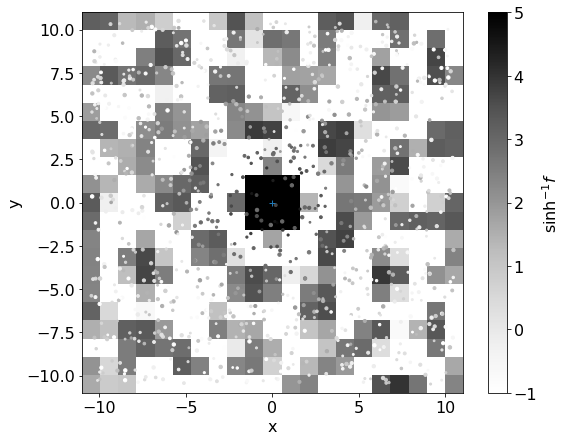

In [73]:
samples.imshow(S_Tg)

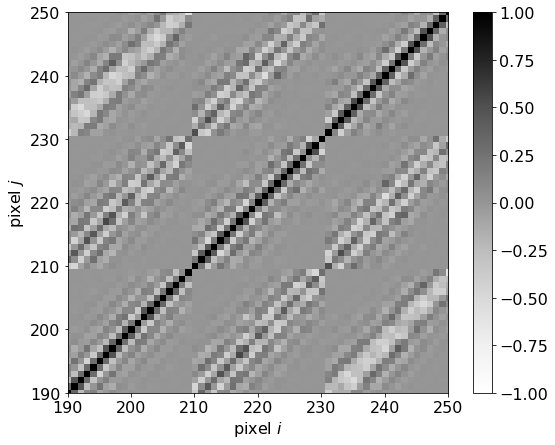

In [74]:
C_Tg = W_Tg.dot(W_Tg.T)
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys, 'vmin': -1., 'vmax': 1}
CC_Tg = 0. * C_Tg
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        CC_Tg[i, j] = C_Tg[i, j] / np.sqrt(C_Tg[i, i] * C_Tg[j, j])
plt.imshow(CC_Tg, **myargs)
nmid = (nx * ny) // 2
plt.xlim([nmid - 30, nmid + 30])
plt.ylim([nmid - 30, nmid + 30])
plt.colorbar()
plt.xlabel('pixel $i$')
plt.ylabel('pixel $j$')